## Data Preprocessing

In [ ]:
import os
from pydub import AudioSegment
import librosa
import soundfile as sf

# Function to convert mp3 files to wav files resampled to 16kHz
def convert_and_resample(mp3_dir, resampled_dir):
    mp3_files = [f for f in os.listdir(mp3_dir) if f.endswith('.mp3')]
    
    for i, mp3_file in enumerate(mp3_files):

        if i >= 10000: # Limit the number of files to convert
            break

        mp3_path = os.path.join(mp3_dir, mp3_file)
        flac_path = os.path.join(resampled_dir, mp3_file.replace('.mp3', '.flac'))
        resampled_path = os.path.join(resampled_dir, mp3_file.replace('.mp3', '.wav'))

        # Convert mp3 to flac
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(flac_path, format="flac")

        # Load the flac file and resample it to 16kHz
        audio, sr = librosa.load(flac_path, sr=None)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        # Save the resampled audio as a wav file
        sf.write(resampled_path, resampled_audio, 16000)

        # Delete the flac file
        os.remove(flac_path)

        print(i)

In [ ]:
mp3_dir = "cv-valid-train-mp3"
resampled_dir = "cv-valid-train"

convert_and_resample(mp3_dir, resampled_dir)

In [ ]:
# Preprocess the CSV file containing the training data
# Removes unimportant columns and limits the number of rows to the amount of data to train/validate on
import pandas as pd

# Load the CSV file
df = pd.read_csv('cv-valid-train.csv')

# List of columns to delete
columns_to_delete = ['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration']

# Delete the columns
df = df.drop(columns_to_delete, axis=1)
df = df.head(10000)

df.info()

In [ ]:
import pandas as pd

# Modify groundtruth text to be uppercase as tokenizer chosen is case-sensitive
df['text'] = df['text'].str.upper()
df['filename'] = df['filename'].str.replace(r'\.mp3$', '.wav', regex=True)

df.head()

In [ ]:
# Save the DataFrame back to CSV
df.to_csv('cv-valid-train.csv', index=False)

In [1]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch

# Custom ASR dataset class for data loading and preprocessing
class ASRDataset(Dataset):
    def __init__(self, csv_path, split):
        self.data = pd.read_csv(csv_path)
        # Splits the data into training and validation sets 70/30
        train_data, val_data = train_test_split(self.data, test_size=0.3, random_state=42)
        
        if split == 'train':
            self.data = train_data
        elif split == 'val':
            self.data = val_data

        # Chosen processor and tokenizer
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

    def __len__(self):
        return len(self.data)

    # Load the audio file and preprocess it
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        speech, _ = torchaudio.load(row["filename"])
        inputs = self.processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)

        return {
            "input_values": torch.flatten(inputs.input_values[0]),
            "labels": torch.tensor(self.processor.tokenizer.encode(row["text"])),
        }

c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create instances of the ASRDataset for training and validation
train_dataset = ASRDataset('cv-valid-train.csv', 'train')
val_dataset = ASRDataset('cv-valid-train.csv', 'val')

In [3]:
print(f"Number of elements in train_dataset: {len(train_dataset)}")
print(f"Number of elements in val_dataset: {len(val_dataset)}")

Number of elements in train_dataset: 7000
Number of elements in val_dataset: 3000


In [3]:
from transformers import Wav2Vec2ForCTC

# Initialize the model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Freeze the feature extractor weights of the model as it is already pre-trained well
model.freeze_feature_extractor()

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

In [4]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

# Code imported from the Hugging Face Transformers library
# This class is used to take a list of features (audio_input and ground truth labels) and pads the tokenized features to the same length
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [5]:
from datasets import load_metric
import numpy as np

wer_metric = load_metric("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


C:\Users\bcheo\AppData\Local\Temp\ipykernel_9720\1600735388.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


## Initializing training arguments

In [6]:
from transformers import TrainingArguments, Trainer

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    gradient_accumulation_steps=2,   
    gradient_checkpointing=True,     
    fp16=True,
    learning_rate=1e-4,
    evaluation_strategy='epoch',     
    logging_strategy='epoch', 
    save_strategy='epoch'                       
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    data_collator=data_collator,
    compute_metrics=compute_metrics        
)

c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Training the model

In [8]:
# Train the model
trainer.train()

  0%|          | 0/2625 [00:00<?, ?it/s]c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
 33%|███▎      | 875/2625 [09:11<16:58,  1.72it/s]  

{'loss': 101.3042, 'grad_norm': 1815.387939453125, 'learning_rate': 8.287058823529412e-05, 'epoch': 1.0}


                                                  
 33%|███▎      | 875/2625 [13:37<16:58,  1.72it/s]

{'eval_loss': 237.29949951171875, 'eval_wer': 0.1553557685580354, 'eval_runtime': 265.9992, 'eval_samples_per_second': 11.278, 'eval_steps_per_second': 0.707, 'epoch': 1.0}


c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
 67%|██████▋   | 1750/2625 [37:41<19:10,  1.31s/it]  

{'loss': 78.1371, 'grad_norm': 1433.7020263671875, 'learning_rate': 4.169411764705883e-05, 'epoch': 2.0}


                                                   
 67%|██████▋   | 1750/2625 [41:04<19:10,  1.31s/it]

{'eval_loss': 187.22486877441406, 'eval_wer': 0.11050864059329742, 'eval_runtime': 202.9309, 'eval_samples_per_second': 14.783, 'eval_steps_per_second': 0.926, 'epoch': 2.0}


c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
100%|██████████| 2625/2625 [1:05:12<00:00,  1.63s/it] 

{'loss': 49.4159, 'grad_norm': 2177.66455078125, 'learning_rate': 5.176470588235294e-07, 'epoch': 3.0}


                                                     
100%|██████████| 2625/2625 [1:08:34<00:00,  1.63s/it]

{'eval_loss': 146.2568359375, 'eval_wer': 0.09014902399776115, 'eval_runtime': 202.6213, 'eval_samples_per_second': 14.806, 'eval_steps_per_second': 0.928, 'epoch': 3.0}


100%|██████████| 2625/2625 [1:08:39<00:00,  1.57s/it]

{'train_runtime': 4119.6945, 'train_samples_per_second': 5.097, 'train_steps_per_second': 0.637, 'train_loss': 76.28576041666666, 'epoch': 3.0}


TrainOutput(global_step=2625, training_loss=76.28576041666666, metrics={'train_runtime': 4119.6945, 'train_samples_per_second': 5.097, 'train_steps_per_second': 0.637, 'train_loss': 76.28576041666666, 'epoch': 3.0})

In [9]:
# Saving model and processor
trainer.save_model("wav2vec2-large-960h-cv")
processor.save_pretrained("wav2vec2-large-960h-cv")

## Training Results

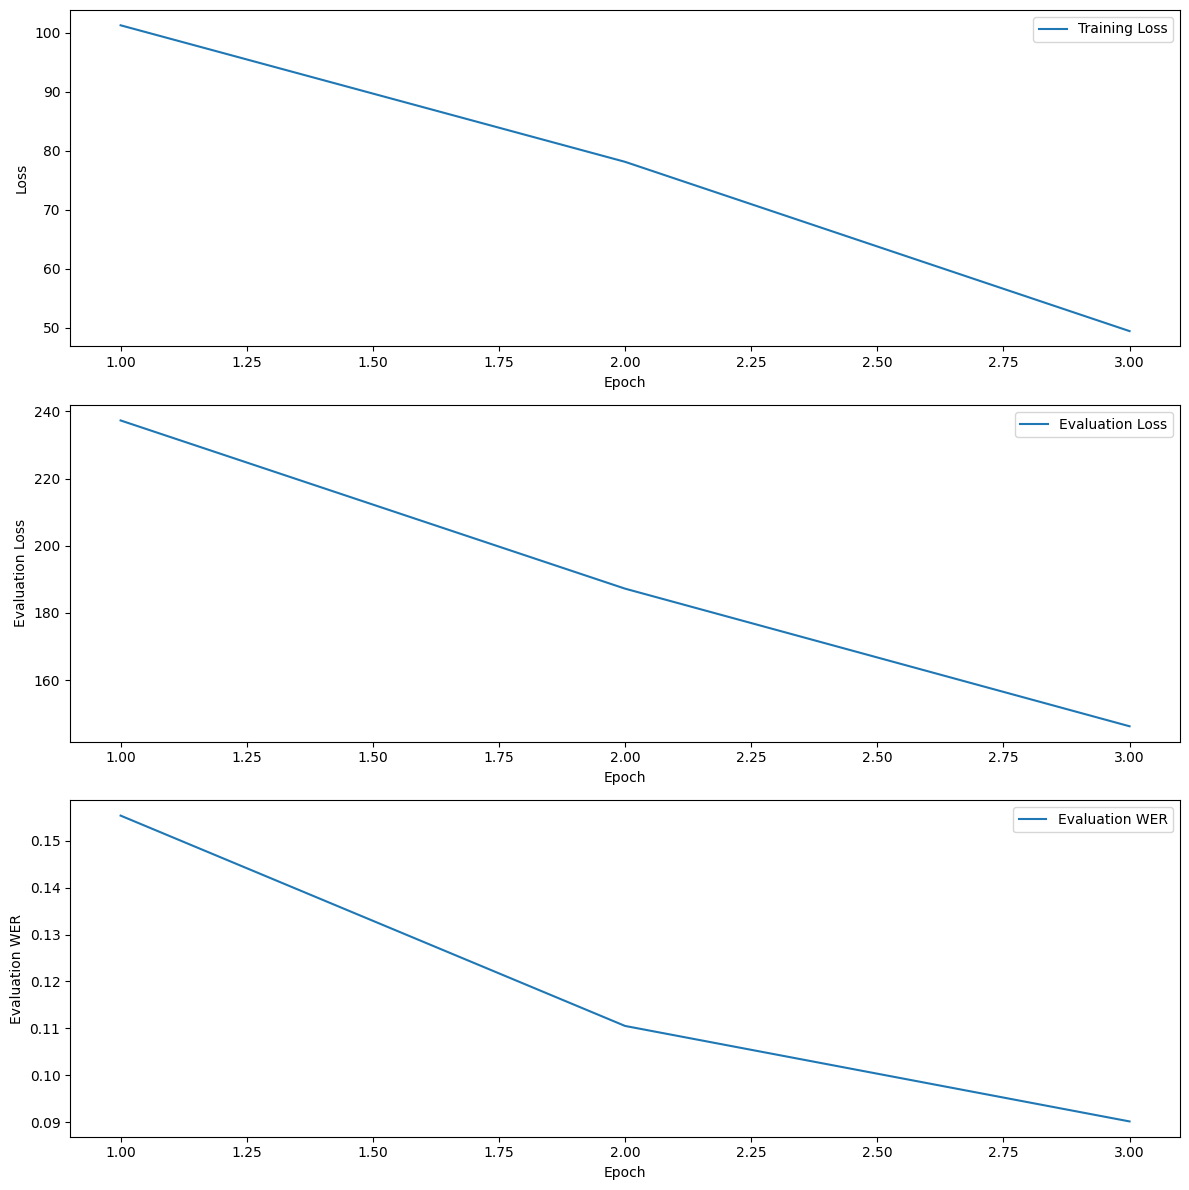

In [1]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('results/checkpoint-2625/trainer_state.json', 'r') as f:
    data = json.load(f)

# Extract the log history
log_history = data['log_history']

# Extract the metrics
epochs = [entry['epoch'] for entry in log_history if 'loss' in entry]
loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_wer = [entry['eval_wer'] for entry in log_history if 'eval_wer' in entry]

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Plot loss over epochs
ax[0].plot(epochs[:len(loss)], loss, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot eval_loss over epochs
ax[1].plot(epochs[:len(eval_loss)], eval_loss, label='Evaluation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Evaluation Loss')
ax[1].legend()

# Plot eval_wer over epochs
ax[2].plot(epochs[:len(eval_wer)], eval_wer, label='Evaluation WER')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Evaluation WER')
ax[2].legend()

plt.tight_layout()
plt.show()

## Fine-tuned Model Evaluation

In [4]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
import pandas as pd
import torch
from jiwer import wer
import soundfile as sf
import librosa

# Load the CSV file
df = pd.read_csv('cv-valid-test.csv')
df['text'] = df['text'].str.upper()

# Initialize fine-tuned model and processor
model = AutoModelForCTC.from_pretrained("wav2vec2-large-960h-cv")
processor = Wav2Vec2Processor.from_pretrained("wav2vec2-large-960h-cv")

# Function to load and preprocess audio, and to generate predictions
def predict_transcription(row):
    audio_input, sr = sf.read(row['filename'])
    resampled_audio = librosa.resample(audio_input, orig_sr=sr, target_sr=16000)
    input_values = processor(resampled_audio, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])

# Generate predictions
df['predicted_transcription'] = df.apply(predict_transcription, axis=1)

# Calculate WER for each prediction
df['wer'] = df.apply(lambda row: wer(row['text'], row['predicted_transcription']), axis=1)

# Display the average WER
print(df['wer'].mean())

0.1001936231119595


In [ ]:
df.to_csv('cv-valid-test.csv', index=False)

In [2]:
import pandas as pd

df = pd.read_csv('cv-valid-test.csv')

df_wer_gt_0 = df[df['wer'] > 0]

# Display and compare examples of ground truth and predicted transcriptions with WER > 0 (Incorrect transcriptions)
for index, row in df_wer_gt_0.sample(n=5).iterrows(): 
    print(f"Ground Truth: {row['text']}")
    print(f"Predicted Transcription: {row['predicted_transcription']}")
    print(f"WER: {row['wer']}")
    print("\n")

Ground Truth: WHERE DO YOU LIVE
Predicted Transcription: WAIYT DO YOU LEAVE
WER: 0.5


Ground Truth: WHO ENGINEERED THIS GETAWAY
Predicted Transcription: AWENGENIEN OF THIS GET AWAY
WER: 1.0


Ground Truth: AND FIND OUT WHERE THE NEAREST TELEGRAPH OFFICE IS
Predicted Transcription: AND FIND OUT WHERE THE MEREST TELEGRAPH OF THIS IS
WER: 0.3333333333333333


Ground Truth: THE BOY WAS ASTONISHED BY WHAT HE SAW INSIDE
Predicted Transcription: THE BOYS WAS ASTIMATED BY WHAT HE SAW INSIDE
WER: 0.2222222222222222


Ground Truth: THE MERCHANTS WERE ASSEMBLING THEIR STALLS AND THE BOY HELPED A CANDY SELLER TO DO HIS
Predicted Transcription: THE MERCHANTS WERE ASSEMBLING THEIR STALLS AND THE BOY HELPED A CANDYSELLER TO DO HIS
WER: 0.125




In [15]:
# Calculating WER for previously generated transcriptions (generated_text)
import pandas as pd
from jiwer import wer

# Load the CSV file
df = pd.read_csv('cv-valid-dev.csv')

# Function to calculate WER for a row
def calculate_wer(row):
    print(f"Processing file: {row['filename']}")
    ground_truth = row['text']
    prediction = row['generated_text']
    if pd.isnull(prediction):
        return 0.0
    return wer(ground_truth, prediction)

# Calculate WER for each row
df['generated_text_wer'] = df.apply(calculate_wer, axis=1)

# Print the average WER
print("Mean generated_text_cv WER: " + str(df['generated_text_wer'].mean()))

Processing file: cv-valid-dev/sample-000000.mp3
Processing file: cv-valid-dev/sample-000001.mp3
Processing file: cv-valid-dev/sample-000002.mp3
Processing file: cv-valid-dev/sample-000003.mp3
Processing file: cv-valid-dev/sample-000004.mp3
Processing file: cv-valid-dev/sample-000005.mp3
Processing file: cv-valid-dev/sample-000006.mp3
Processing file: cv-valid-dev/sample-000007.mp3
Processing file: cv-valid-dev/sample-000008.mp3
Processing file: cv-valid-dev/sample-000009.mp3
Processing file: cv-valid-dev/sample-000010.mp3
Processing file: cv-valid-dev/sample-000011.mp3
Processing file: cv-valid-dev/sample-000012.mp3
Processing file: cv-valid-dev/sample-000013.mp3
Processing file: cv-valid-dev/sample-000014.mp3
Processing file: cv-valid-dev/sample-000015.mp3
Processing file: cv-valid-dev/sample-000016.mp3
Processing file: cv-valid-dev/sample-000017.mp3
Processing file: cv-valid-dev/sample-000018.mp3
Processing file: cv-valid-dev/sample-000019.mp3
Processing file: cv-valid-dev/sample-000

In [6]:
df = pd.read_csv('cv-valid-dev.csv')
df_wer_gt_0 = df[df['generated_text_wer'] > 0]

for index, row in df_wer_gt_0.sample(n=5).iterrows(): 
    print(f"Ground Truth: {row['text']}")
    print(f"Generated_Text: {row['generated_text']}")
    print(f"WER: {row['generated_text_wer']}")
    print("\n")

Ground Truth: I DARE HER TO MOVE THAT DESK OUT OF HERE
Generated_Text: I DARE HEAR TO MOVE THAT DESK OUT UF HERE
WER: 0.2


Ground Truth: HE HAD ALWAYS BELIEVED THAT THE SHEEP WERE ABLE TO UNDERSTAND WHAT HE SAID
Generated_Text: HE HAD ALWAYS BELIEVED THAT HA SHEEP WERE ABLE TO UNDERSTAND WHAT HE SAID
WER: 0.0714285714285714


Ground Truth: LET ME COMB YOUR HAIR
Generated_Text: LET ME CARM YOUR HAIR
WER: 0.2


Ground Truth: I'M SURPRISED THE BOY SAID
Generated_Text: I AM SURPRISED THE BOY SAID
WER: 0.4


Ground Truth: THE TELLER DIDN'T HAVE ENOUGH CHANGE
Generated_Text: THE TENLER DIDN'T HOW LOG CHAIN
WER: 0.6666666666666666




In [3]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
import pandas as pd
import torch
from jiwer import wer
import soundfile as sf
import librosa

# Load the CSV file
df = pd.read_csv('cv-valid-dev.csv')
df['text'] = df['text'].str.upper()

# Initialize model and processor
model = AutoModelForCTC.from_pretrained("wav2vec2-large-960h-cv")
processor = Wav2Vec2Processor.from_pretrained("wav2vec2-large-960h-cv")

# Function to load and preprocess audio, and to generate predictions
def predict_transcription(row):
    print(f"Processing file: {row['filename']}")
    audio_input, sr = sf.read(row['filename'])
    resampled_audio = librosa.resample(audio_input, orig_sr=sr, target_sr=16000)
    input_values = processor(resampled_audio, sampling_rate=16000, return_tensors="pt").input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])

# Generate predictions
df['generated_text_cv'] = df.apply(predict_transcription, axis=1)

# Calculate WER for each prediction
df['generated_text_cv_wer'] = df.apply(lambda row: wer(row['text'], row['generated_text_cv']), axis=1)

# Print the average WER
print("Mean generated_text_cv WER: " + str(df['generated_text_cv_wer'].mean()))

c:\Users\bcheo\anaconda3\envs\htx\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing file: cv-valid-dev/sample-000000.mp3
Processing file: cv-valid-dev/sample-000001.mp3
Processing file: cv-valid-dev/sample-000002.mp3
Processing file: cv-valid-dev/sample-000003.mp3
Processing file: cv-valid-dev/sample-000004.mp3
Processing file: cv-valid-dev/sample-000005.mp3
Processing file: cv-valid-dev/sample-000006.mp3
Processing file: cv-valid-dev/sample-000007.mp3
Processing file: cv-valid-dev/sample-000008.mp3
Processing file: cv-valid-dev/sample-000009.mp3
Processing file: cv-valid-dev/sample-000010.mp3
Processing file: cv-valid-dev/sample-000011.mp3
Processing file: cv-valid-dev/sample-000012.mp3
Processing file: cv-valid-dev/sample-000013.mp3
Processing file: cv-valid-dev/sample-000014.mp3
Processing file: cv-valid-dev/sample-000015.mp3
Processing file: cv-valid-dev/sample-000016.mp3
Processing file: cv-valid-dev/sample-000017.mp3
Processing file: cv-valid-dev/sample-000018.mp3
Processing file: cv-valid-dev/sample-000019.mp3
Processing file: cv-valid-dev/sample-000

In [17]:
df.to_csv('cv-valid-dev.csv', index=False)

In [10]:
# Filter the DataFrame
df_wer_gt_0 = df[df['wer'] > 0]

# Print some examples
for index, row in df_wer_gt_0.sample(n=5).iterrows(): 
    print(f"Ground Truth: {row['text']}")
    print(f"Predicted Transcription: {row['predicted_transcription']}")
    print(f"WER: {row['wer']}")
    print("\n")

Ground Truth: WE MUST GET SOME OF THAT SERUM AS SOON AS POSSIBLE
Predicted Transcription: WE MUST GET SOME OF THAT CYRUM AS SOON AS POSSIBLE
WER: 0.09090909090909091


Ground Truth: THERE WAS A GENERAL MOVEMENT BACKWARDS
Predicted Transcription: THERE WERE THE GENERAL MOVING BACKWARDS
WER: 0.5


Ground Truth: THE BIG GUY THERE
Predicted Transcription: THE BIG GUIN THERE
WER: 0.25


Ground Truth: SOMEHOW THE PARAGRAPHS BLURRED INTO EACH OTHER
Predicted Transcription: SOMEHOW THE PARAGRAPHS BLUWED INTO EACH OTHER
WER: 0.14285714285714285


Ground Truth: A GREAT HUMANITARIAN AND THE BEST FRIEND THE JESSIE BAKERS HAVE
Predicted Transcription: A GREAT HUMANITARION AND THE BEST FRIEND THE JESSIE BAKERS HAVE
WER: 0.09090909090909091


